# Loss and time for batch/learning rate combinations

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [4]:
!ls -l logs/microseries/

total 0
drwxr-xr-x  42 peterbryzgalov  staff  1428 Apr  3 16:47 GTX_TITAN_X


In [62]:
logdir = "logs/microseries/GTX_TITAN_X/loss"

In [9]:
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
len(files)

40

In [24]:
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern
    batch_learn_pattern = "_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)"
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = re.search(batch_learn_pattern, filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0 # DataFrame row numebr (index)
        df = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                if debug: print line,
                epoch = int(m2.group(1))
                time = float(m2.group(2))
                loss = float(m2.group(3))        
                if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
                df.loc[ind] = [batch,learn,run,epoch,time,loss]
                ind += 1                    
    return df

In [25]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    
    filename_pattern=re.compile(r"imagecaption_.*\.log")
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])

    filecounter=0
    for file in files:
        if debug: print file
        df1 = fileToDF(file,debug)
        if len(df1) > 0:
            df = pd.concat([df,df1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return df

In [26]:
df_DL=readLogs("logs/microseries/GTX_TITAN_X")

In [27]:
df_DL[.head()

,batch,lr,run,epoch,time,loss
0,12.0,0.001,0.0,1.0,29.112987,6.617882
1,12.0,0.001,0.0,2.0,27.854918,6.576118
2,12.0,0.001,0.0,3.0,28.256412,6.548199
3,12.0,0.001,0.0,4.0,28.972898,6.432320
4,12.0,0.001,0.0,5.0,28.339761,6.421024


In [51]:
df_5 = df_DL[df_DL["epoch"]==5.]
df_5[df_5["batch"]==4.]

,batch,lr,run,epoch,time,loss
124,4.0,0.001,0.0,5.0,15.052591,6.577137
129,4.0,0.001,1.0,5.0,15.504801,6.651340
134,4.0,0.002,0.0,5.0,15.248072,6.538705
139,4.0,0.002,1.0,5.0,15.362160,6.582397
144,4.0,0.003,0.0,5.0,14.919148,6.843698
149,4.0,0.003,1.0,5.0,15.953676,6.870876
154,4.0,0.004,0.0,5.0,15.178517,6.878681
159,4.0,0.004,1.0,5.0,15.365081,6.957091


In [56]:
df_mean = df_5.groupby(["batch","lr","epoch"]).mean().reset_index()
print df_mean.head()
df_mean = df_mean.drop(["epoch","run"],axis=1)
df_mean[df_mean["batch"]==4]

   batch     lr  epoch  run       time      loss
0    4.0  0.001    5.0  0.5  15.278696  6.614238
1    4.0  0.002    5.0  0.5  15.305116  6.560551
2    4.0  0.003    5.0  0.5  15.436412  6.857287
3    4.0  0.004    5.0  0.5  15.271799  6.917886
4    8.0  0.001    5.0  0.5  21.846986  6.376563


,batch,lr,time,loss
0,4.0,0.001,15.278696,6.614238
1,4.0,0.002,15.305116,6.560551
2,4.0,0.003,15.436412,6.857287
3,4.0,0.004,15.271799,6.917886


In [58]:
def plotHeatMap(df,title=None,cmap=None):
    plt.rcParams['figure.figsize'] = 10,8 
    plt.pcolormesh(df,cmap=cmap)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    ax = plt.gca()
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                plt.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.2, 'pad':0})
    plt.title(title,fontsize=18)
    plt.xlabel("learning rate",fontsize=12)
    plt.ylabel("minibatch size",fontsize=12)
    plt.colorbar()
    plt.show()

In [59]:
time_T = df_mean.pivot_table(index="batch",columns="lr",values="time")
loss_T = df_mean.pivot_table(index="batch",columns="lr",values="loss")

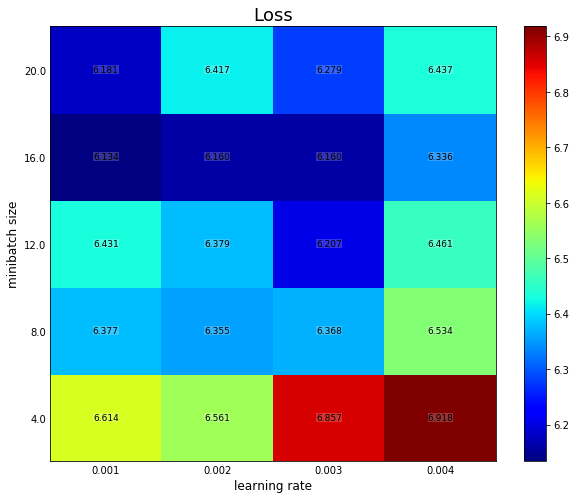

In [60]:
plotHeatMap(loss_T,"Loss","jet")

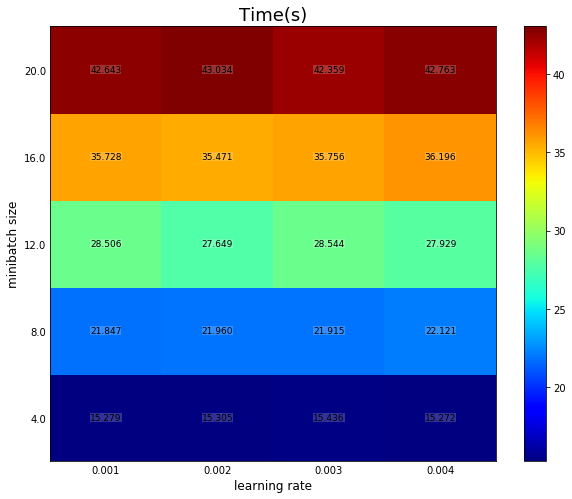

In [61]:
plotHeatMap(time_T,"Time(s)","jet")